# Data preprocessing, filtering & exploration

In [1]:
!whoami
!date
!pwd
!nvidia-smi

root
Thu May 11 12:58:55 UTC 2017
/notebooks/CODE/project_warms
Thu May 11 12:58:55 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.39                 Driver Version: 375.39                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 0000:05:00.0     Off |                  N/A |
| 23%   37C    P8    16W / 250W |      0MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:            

In [2]:
dir_images = '/notebooks/CODE/project_warms/BBBC010_v1_images/'
dir_foreground = '/notebooks/CODE/project_warms/BBBC010_v1_foreground/'
dir_data = '/notebooks/CODE/project_warms/HDF5/'

In [5]:
# !pip install tqdm
# !pip install scikit-image

    100% |################################| 51kB 506kB/s ta 0:00:01
    100% |################################| 34.0MB 2.9kB/s ta 0:00:011
    100% |################################| 5.7MB 31kB/s eta 0:00:01
    100% |################################| 1.3MB 467kB/s ta 0:00:01


In [12]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import matplotlib.cm as cm

from matplotlib.pyplot import imshow
import matplotlib.patches as patches

import os
import pandas
from pandas import Series
import copy

# suppress e+10... notation
pandas.set_option('display.float_format', lambda x: '%.3f' % x)

from glob import glob

import random

import h5py
import gzip

import re
import itertools

from __future__ import division # to avoid integer division

# progress bar to monitor loops
from tqdm import *

# pylab.rcParams['figure.figsize'] = (20.0, 20.0)
from PIL import Image

import skimage
import time

from skimage import data, io, draw #http://scikit-image.org/docs/stable/
from skimage import transform
from skimage.io import imread

%matplotlib inline

import sys
# sys.path.insert(0, '../../../code/deep_cells/cell_cutting/')
# sys.path.insert(0, '/home/tolk/deepcells/code_exp/task7_amgen/helper_functions/cell_cutting/')

# # import cutting and scaling functions
# from cell_cutting_utils import *
# from grep_vec import *
import collections

# Preprocess raw images

In [15]:
os.getcwd()

'/notebooks/CODE/project_warms/BBBC010_v1_images'

In [14]:
os.chdir(dir_images)

In [16]:
names = glob( dir_images + '*.tif')
names.sort()

In [17]:
len(names)

195

## Create a look-up dataframe of images

In [13]:
## make a dictionary of all the available image files
# The images are named using this format: <plate>_<wellrow>_<wellcolumn>_<wavelength>_<fileid>.tif

In [18]:
df_images = np.zeros( len(names),
                     dtype=[('well_name', 'S3'),
                            ('well_col', 'int8'),
                            ('channel', 'int8'), 
                            ('size_KB', 'float16'), 
                            ('file_name', 'S150'),
                            ('well_index', 'S10')
                           ] )

### create a fast look-up dictionary with image file names
pos2filename = {}

for row, name in enumerate( names ) :
    
    d = name.split('/')[-1] 
    
    well_name = re.findall( '_([A-Z][0-9][0-9])_w', d)[0]

    channel = re.findall( '_w([1-2])', d)[0]
    pos2filename[ str(well_name) + '_' + str(channel) ] = name
       
    df_images[row]['well_name'] = well_name
    df_images[row]['well_col'] = re.findall( '([0-9][0-9])', well_name)[0]
        
    df_images[row]['channel'] = channel
    df_images[row]['size_KB']  = os.stat(name).st_size/1000.0
    df_images[row]['file_name'] = name
    df_images[row]['well_index'] = well_name + '_' + channel

df_images = pandas.DataFrame( df_images )


In [19]:
df_images.tail()

,well_name,well_col,channel,size_KB,file_name,well_index
190,b'E02',2,2,726.000,b'/notebooks/CODE/project_warms/BBBC010_v1_ima...,b'E02_2'
191,b'E03',3,1,726.000,b'/notebooks/CODE/project_warms/BBBC010_v1_ima...,b'E03_1'
192,b'E03',3,2,726.000,b'/notebooks/CODE/project_warms/BBBC010_v1_ima...,b'E03_2'
193,b'E04',4,1,726.000,b'/notebooks/CODE/project_warms/BBBC010_v1_ima...,b'E04_1'
194,b'E04',4,2,726.000,b'/notebooks/CODE/project_warms/BBBC010_v1_ima...,b'E04_2'


### find if there're some channels missing from wells

In [20]:
tab = pandas.crosstab( df_images.well_name, df_images.channel)
tab.iloc[ np.where(tab == 0)]

channel,2
well_name,
b'D24',0


In [21]:
# Channel 2 is missing from well D24, drop it.
df_images = df_images[ df_images.well_name != b'D24' ]

In [22]:
df_images.shape

(194, 6)

# Images overview

In [23]:
print(well_name)
im0_path = pos2filename[well_name + '_' + '1'] # channel 1
im1_path = pos2filename[well_name + '_' + '2'] # channel 2

im0 = imread(im0_path)
im1 = imread(im1_path)

E04


In [24]:
im0.shape

(520, 696)

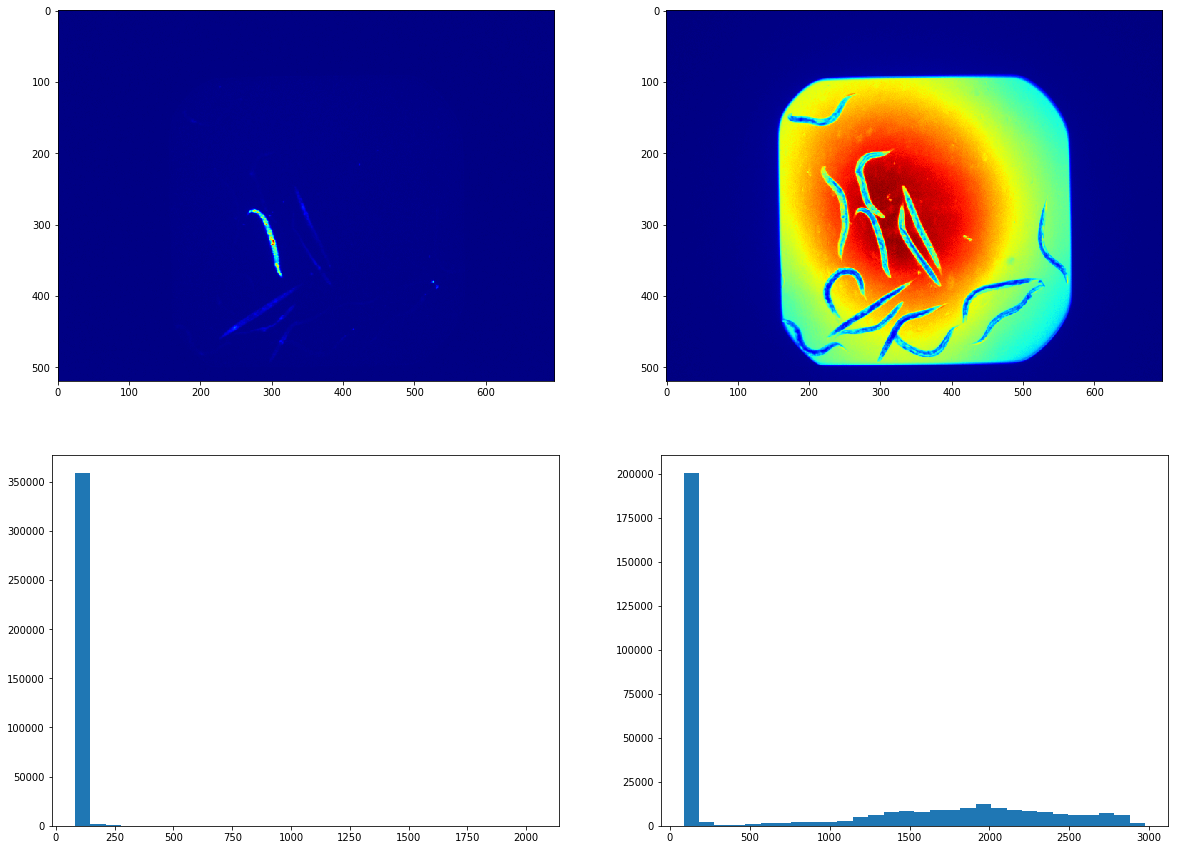

In [25]:
fig, ax = plt.subplots(1, 1, figsize = (20,15))

plt.subplot(221)
plt.imshow( im0, cmap = cm.jet, aspect = 'equal' );
    
plt.subplot(222)
plt.imshow( im1, cmap = cm.jet, aspect = 'equal' );

plt.subplot(223)
plt.hist(im0.flatten(), bins=30 );

plt.subplot(224)
plt.hist(im1.flatten(), bins=30);

## histograms for all images per channel

In [39]:
well_names =  np.unique(df_images['well_name'])

In [29]:
channel_1 = []
channel_2 = []

for well_name in well_names:
    
    well_name = well_name.decode('UTF-8')
    im0_path = pos2filename[well_name + '_' + '1'] # channel 2
    im1_path = pos2filename[well_name + '_' + '2'] # channel 2
    
    im0 = imread(im0_path)
    im1 = imread(im1_path)
    channel_1.append(im0.flatten().tolist())
    channel_2.append(im1.flatten().tolist())
    
channel_1 = list(itertools.chain(*channel_1))
channel_2 = list(itertools.chain(*channel_2))

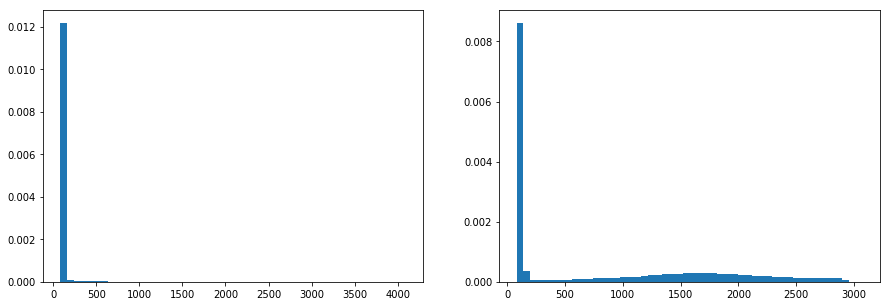

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))

plt.subplot(121)
plt.hist(channel_1, bins = 50, normed = True, label = 'channel 1' );

plt.subplot(122)
plt.hist(channel_2, bins = 50, normed = True, label = 'channel 2' );

## Important comments:
It's obvious that both channels have dark frames (well walls) and the 2nd channel has radial noise around the center.
These can be filtered out with, for example, z-transformation.
However, from the Broad institute the phenotypes of the worms are known to have clear shape features: 
    - the negative (infected and not treated) are 'dead' and thus straight, rod-like (label == 0)
    - the positive (infected and treated with antibiotic) are 'alive' and curvy (label == 1)
    
In other words, we are only looking to detect the worms shape to classify them properly and not their color, space in between, etc.
Therefore, by thresholding both channels with intensity > 250, we are able to obtain a binary mark of warms vs. 
background with the frame.

Eventually, we could either threshold the channels or utilize the foreground binary images which have the worms already
segemented vs. the background.

After that we need to apply a decent shape detector to classify the worms. 
VGG16 features serve very well in this case, so we propagate the images through VGG16 until fc8 layer,
extract its features and apply a few traditional classifiers on them, linear SVM and Random Forest.

## Introduce labels

In [31]:
# from the dataset description it's known that:
# Columns 1-12 are positive controls treated with ampicillin. (label == 1)
# Columns 13-24 are untreated negative controls. (label == 0)

In [32]:
df_images['label'] = 0
df_images.loc[  df_images.well_col <= 12, 'label'] = 1

In [33]:
labels = df_images[ ['well_index', 'label'] ]
labels.to_csv('/notebooks/CODE/project_warms/HDF5/labels.csv',
             sep = ',',
             encoding = 'utf-8',
             index = False)

In [ ]:
# df_images.to_csv('/notebooks/CODE/project_warms/HDF5/images_info.csv',
#              sep = ',',
#              encoding = 'utf-8',
#              index = False)

### distribution of labels

In [35]:
labels.label.value_counts()

1    104
0     90
Name: label, dtype: int64

## Assemble raw images into hdf5 array for easy input into a neural net

In [41]:
im0.shape

(520, 696)

In [44]:
hdf5_X = h5py.File( dir_data + 'X_raw.hdf5', 'w')

X = hdf5_X.create_dataset( 'X_raw', 
                      shape = ( len(well_names), 520, 696, 2 ),
                      dtype = 'float32',
                      fillvalue = -1)

In [ ]:
for row, well_name in enumerate(tqdm(well_names)):
    
    # channel 1
    im0_path = df_images.loc[ (df_images.well_name == well_name) & (df_images.channel == 1), 'file_name']
    
    # channel 2
    im1_path = df_images.loc[ (df_images.well_name == well_name) & (df_images.channel == 2), 'file_name']
    
    im0_path = im0_path.iloc[0].decode()
    im1_path = im1_path.iloc[0].decode()

    X[ row, :, :, 0 ]  = imread( im0_path )
    X[ row, :, :, 1 ]  = imread( im1_path )

In [46]:
X.shape

(97, 520, 696, 2)

In [47]:
hdf5_X.close()

#======================================================================================================================

# Proprocess foreground images

In [58]:
dir_foreground

'/notebooks/CODE/project_warms/BBBC010_v1_foreground/'

In [59]:
os.chdir(dir_foreground)

In [60]:
names_foreground = glob( dir_foreground + '*.png')
names_foreground.sort()

In [61]:
len(names_foreground)

100

## Create a look-up dataframe of images

In [62]:
df_foreground = np.zeros( len(names_foreground),
                     dtype=[('well_name', 'S3'),
                            ('well_col', 'int8'),
                            ('size_KB', 'float16'), 
                            ('file_name', 'S150')
                           ] )

for row, name in enumerate( names_foreground ) :
    
    d = name.split('/')[-1] 
    
    well_name = re.findall( '([A-Z][0-9][0-9])_binary.png', d)[0]

    df_foreground[row]['well_name'] = well_name
    df_foreground[row]['well_col'] = re.findall( '([0-9][0-9])', well_name)[0]

    df_foreground[row]['size_KB']  = os.stat(name).st_size/1000.0
    df_foreground[row]['file_name'] = name

df_foreground = pandas.DataFrame( df_foreground )


In [63]:
df_foreground.head()

,well_name,well_col,size_KB,file_name
0,b'A01',1,6.414,b'/notebooks/CODE/project_warms/BBBC010_v1_for...
1,b'A02',2,6.465,b'/notebooks/CODE/project_warms/BBBC010_v1_for...
2,b'A03',3,6.188,b'/notebooks/CODE/project_warms/BBBC010_v1_for...
3,b'A04',4,6.008,b'/notebooks/CODE/project_warms/BBBC010_v1_for...
4,b'A05',5,6.438,b'/notebooks/CODE/project_warms/BBBC010_v1_for...


## Add labels

In [41]:
df_foreground['label'] = 0
df_foreground.loc[  df_foreground.well_col <= 12, 'label'] = 1

In [48]:
labels_foreground = df_foreground[ ['well_name', 'label'] ]
labels_foreground.to_csv('/notebooks/CODE/project_warms/HDF5/labels_foreground.csv',
             sep = ',',
             encoding = 'utf-8',
             index = False)

In [49]:
df_foreground.to_csv('/notebooks/CODE/project_warms/HDF5/foreground_info.csv',
             sep = ',',
             encoding = 'utf-8',
             index = False)

In [64]:
print(well_name)
im0_path = df_foreground.loc[ df_foreground.well_name == b'E04', 'file_name']
im0_path = im0_path.iloc[0].decode()
im0 = imread(im0_path)

E04


# Images overview

In [66]:
im0.shape

(520, 696, 4)

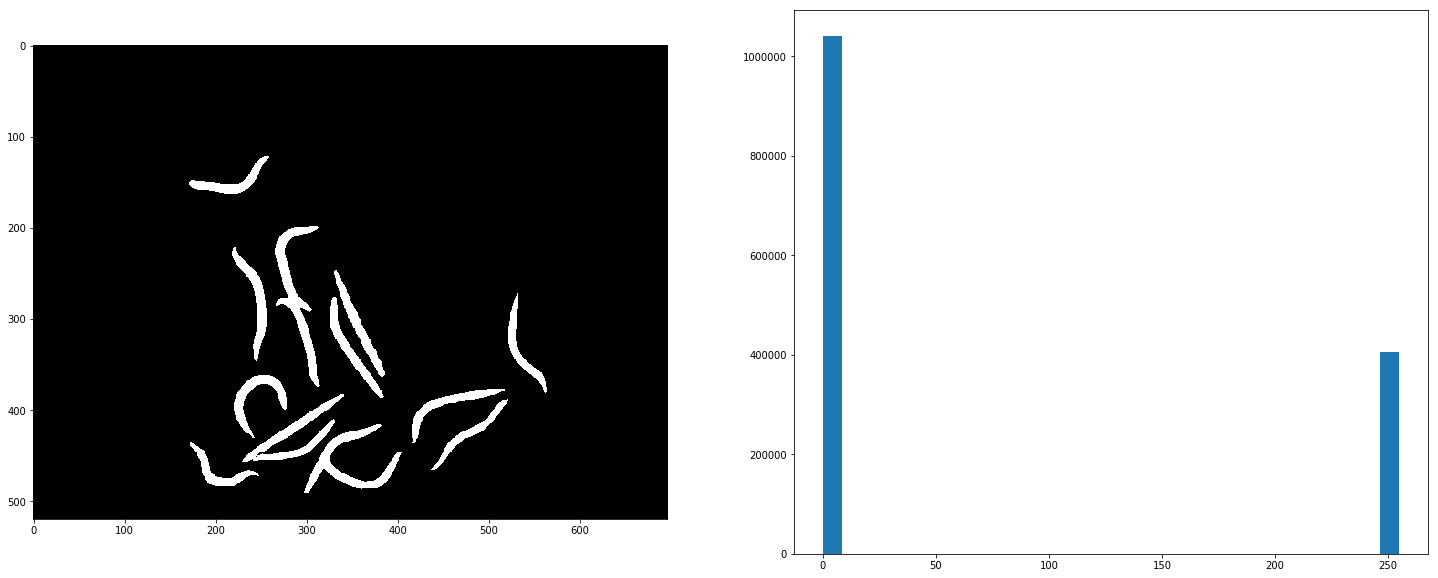

In [67]:
fig, ax = plt.subplots(1, 1, figsize = (25,10))

plt.subplot(121)
plt.imshow( im0, cmap = cm.jet, aspect = 'equal' );
    
plt.subplot(122)
plt.hist(im0.flatten(), bins=30 );

## Assemble raw foreground images into hdf5 array for easy input into a neural net

In [93]:
im0.shape

(520, 696, 4)

In [95]:
well_names =  np.unique(df_foreground['well_name'])

In [116]:
hdf5_X = h5py.File( dir_data + 'X_foreground.hdf5', 'w')

X = hdf5_X.create_dataset( 'X_foreground', 
                      shape = ( len(well_names), 520, 696, 1 ),
                      dtype = 'float32',
                      fillvalue = -1)

In [117]:
for row, well_name in enumerate(tqdm(well_names)):
    
    # channel 1
    im0_path = df_foreground.loc[ (df_foreground.well_name == well_name), 'file_name']
            
    im0_path = im0_path.iloc[0].decode()
    
    X[ row, :, :, 0 ]  = imread( im0_path )[:, :,0]

100%|██████████| 100/100 [00:01<00:00, 53.45it/s]


In [119]:
hdf5_X.close()